# Improving an Existing Image Classifier (Fine Tuning)

## Introduction

In my previous notebook, `01 - CNN based image classification.ipynb`, I started learning about `Image Classification using the Supervised Learning` and how it can assist me categorizing images. The image classification model classifies images into two categories:

- `Illustration`: Images that do not contain any accompanying text or dialogue.
- `Manga`: Images that do contain text or dialogue.

Instead of starting from scratch, my aim is to enhance the performance of the existing image classifier model. 
My objective remains unchanged: to classify images into the `Illustration` and `Manga` categories. 
However, I will employ `fine-tuning` technique to improve the classifier model. 
The existing model will be tuned using a larger image dataset, so it becomes more expert at distinguishing between `Illustration` and `Manga` images.

## Programming

In [1]:
import sys
sys.dont_write_bytecode = True

import os
import tensorflow as tf

# Custom library module
from model.ImportModel import ImportModel
from module.DatasetProcessor import DatasetProcessor
from script.plot_training_history import plot_training_history

### Configuration

In [2]:
CFG = {
    "dataset_dir": ".\DATASET\ILLUST VS MANGA", # Dataset directory path
    "h5": ".\export model\Res2Net50SE_224x224_2Class (ILLUST VS MANGA).h5",
    "batch": 8, # Batch size
    "optimizer": tf.keras.optimizers.Adam(learning_rate=1e-6, decay=1e-2), # Set very low learning rate for whole fine tuning model
    "loss_func": tf.losses.CategoricalCrossentropy(), # Loss function (Categorical Cross-Entropy)
}

### Initializing

In [3]:
# Avoid out of memory errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

### Declare functions
- `Custom_ImageDataGenerator`
- `raw_data_processing`

In [4]:
def Custom_ImageDataGenerator(image_path, label, image_size):
    # Read the image file from the given path
    image = tf.io.read_file(image_path)
    
    # Decode the image into a tensor, disabling animation expansion
    image = tf.image.decode_image(image, expand_animations=False)
    
    # Resize the image to the specified dimensions while preserving aspect ratio and using antialiasing
    image = tf.image.resize(image, (image_size, image_size),
                            preserve_aspect_ratio=True,
                            antialias=True)
    
    # Resize the image with padding to ensure it has the exact dimensions specified
    image = tf.image.resize_with_pad(image, image_size, image_size)
    
    # Normalize the image pixel values to the range [0, 1] by dividing by 255.0
    image = image / 255.0
    
    return image, label

In [5]:
def raw_data_processing(data_list, dict_class, image_size):
    # Extract the image file paths from the data_list
    path_list = [path for path, _ in data_list]
    
    # Map class labels to their corresponding dictionary values
    label_list = [dict_class[label] for _, label in data_list]
    
    # Create a list of image size values to be used as a constant size in the dataset
    size_list = [image_size] * len(label_list)
    
    # Create a TensorFlow dataset from the extracted lists
    dataset = tf.data.Dataset.from_tensor_slices((path_list, label_list, size_list))
    
    return dataset

### Model loading


In [6]:
model = ImportModel(CFG["h5"])

### Dataset preparation

In [7]:
# Create a list of tuples, where each tuple contains the image path and its class label
path_list = [os.path.join(root,image) for root, _, files in os.walk(CFG["dataset_dir"], topdown=True) for image in files]
path_list = [(path, path.split('\\')[-2]) for path in path_list]

In [8]:
# Call custom class module
processor = DatasetProcessor(path_list)
processor.print_raw()

2160 data including
ILLUSTRATION: 1196
MANGA: 964


In [9]:
# Prepare class list and its corresponding dictionary for class-label mapping
processor.create_class_dict(mode="onehot")

processor.class_list, processor.class_dict

(['ILLUSTRATION', 'MANGA'],
 {'ILLUSTRATION': array([1., 0.], dtype=float32),
  'MANGA': array([0., 1.], dtype=float32)})

In [10]:
# Split the dataset into training and testing datasets
processor.train_test_splitter(test_ratio=10)

len(processor.train_data), len(processor.test_data)

1944 train data including
ILLUSTRATION: 1076
MANGA: 868
216 test data including
ILLUSTRATION: 120
MANGA: 96
ILLUSTRATION class has weight: 0.9033
MANGA class has weight: 1.1198


(1944, 216)

In [11]:
# Prepare the training dataset
train_dataset = raw_data_processing(processor.train_data, processor.class_dict, model.image_size)
train_dataset = train_dataset.map(Custom_ImageDataGenerator)
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(buffer_size=len(train_dataset))
train_dataset = train_dataset.batch(batch_size=CFG["batch"], drop_remainder = True)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

# Prepare the testing dataset
test_dataset = raw_data_processing(processor.test_data, processor.class_dict, model.image_size)
test_dataset = test_dataset.map(Custom_ImageDataGenerator)
test_dataset = test_dataset.batch(batch_size=CFG["batch"], drop_remainder = False)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

### Fine tuning the existing model

In [12]:
# Create an Early Stopping callback that monitors validation loss and stops training if it doesn't improve significantly
EarlyStop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                     min_delta=0.01, 
                                                     patience=20, 
                                                     restore_best_weights=True, 
                                                     verbose=1)

# Compile the model with the specified optimizer and loss function
model.compile(optimizer=CFG["optimizer"], loss=CFG["loss_func"])

# Train the model on the training dataset with early stopping and a maximum of 100 epochs
model.train(train_dataset, test_dataset, epochs=1000, callbacks=[EarlyStop])

Epoch 1/1000
243/243 [==============================] - 166s 538ms/step - loss: 0.1530 - accuracy: 0.9367 - val_loss: 0.0699 - val_accuracy: 0.9815
Epoch 2/1000
243/243 [==============================] - 129s 531ms/step - loss: 0.1415 - accuracy: 0.9475 - val_loss: 0.0672 - val_accuracy: 0.9815
Epoch 3/1000
243/243 [==============================] - 128s 526ms/step - loss: 0.1458 - accuracy: 0.9480 - val_loss: 0.0642 - val_accuracy: 0.9815
Epoch 4/1000
243/243 [==============================] - 128s 527ms/step - loss: 0.1259 - accuracy: 0.9532 - val_loss: 0.0599 - val_accuracy: 0.9815
Epoch 5/1000
243/243 [==============================] - 128s 527ms/step - loss: 0.1322 - accuracy: 0.9568 - val_loss: 0.0623 - val_accuracy: 0.9815
Epoch 6/1000
243/243 [==============================] - 129s 529ms/step - loss: 0.1311 - accuracy: 0.9516 - val_loss: 0.0598 - val_accuracy: 0.9815
Epoch 7/1000
243/243 [==============================] - 128s 528ms/step - loss: 0.1467 - accuracy: 0.9393 - val_

### Model evaluation by plotting history

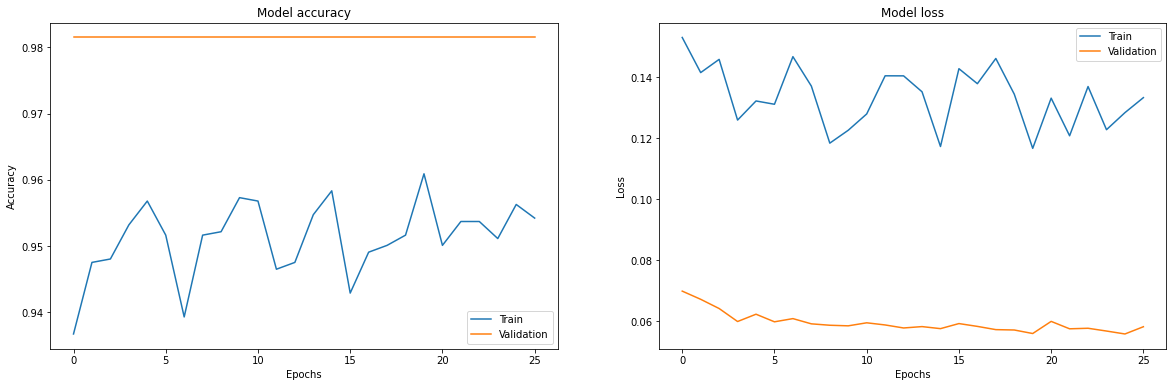

In [13]:
plot_training_history(model.history)

### Export model

In [14]:
model_name = model.model.name + "_fine-tune"
model.save(model_name)